# Intro to SAM point prompts + mosaic art on the SAM mask

This notebook has two parts:

Part A, SAM basics
1. Load one image
2. Give SAM a point prompt (foreground point)
3. Pick the best mask
4. Optionally refine with extra points
5. Save a clean binary mask

Part B, use the SAM mask for art
1. Build a density field from brightness and edges
2. Restrict that density to the SAM mask
3. Sample points inside the mask
4. Render two outputs
   - Voronoi-style mosaic inside the mask (hard boundary match)
   - Triangle mesh shading inside the mask


In [ ]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

print("Python:", sys.version.split()[0])
print("Working dir:", os.getcwd())
try:
    import torch
    print("Torch:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("GPU:", torch.cuda.get_device_name(0))
except Exception as e:
    print("Torch not available yet:", repr(e))


Python: 3.12.12
Working dir: /content
Torch: 2.9.0+cpu
CUDA available: False


## 1. Install SAM and dependencies

This installs:
- opencv for image I/O
- segment_anything from Meta's GitHub repo


In [ ]:
!pip -q install opencv-python matplotlib
!pip -q install 'git+https://github.com/facebookresearch/segment-anything.git'

print("Install complete.")

  Preparing metadata (setup.py) ... done
Install complete.


## 2. Download demo assets

We download:
- A demo image
- A SAM checkpoint (ViT-H)

Notes:
- ViT-H is large and slower, but usually gives the best masks.
- If you want faster later, switch to vit_l or vit_b.


In [ ]:
import os
os.makedirs("images", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("outputs", exist_ok=True)
# Demo images
!wget -q -O images/truck.jpg https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
!wget -q -O images/groceries.jpg https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
# Checkpoint
!wget -q -O checkpoints/sam_vit_h_4b8939.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
print("images:", os.listdir("images"))
print("checkpoints:", os.listdir("checkpoints"))
print("outputs:", os.listdir("outputs"))

## 3. Load an image

Option A: use a demo image (truck or groceries).

Option B: upload your own image!
If you upload, set `IMAGE_PATH` to the uploaded filename.


In [ ]:
import cv2
# Choose one:
IMAGE_PATH = "images/truck.jpg"
# IMAGE_PATH = "images/groceries.jpg"
# Load RGB image
image_bgr = cv2.imread(IMAGE_PATH)
if image_bgr is None:
    raise FileNotFoundError(f"Could not load image at {IMAGE_PATH}")
image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
H, W = image.shape[:2]

plt.figure(figsize=(8,8))
plt.imshow(image)
plt.title("Input image")
plt.axis("off")
plt.show()

FileNotFoundError: Could not load image at images/truck.jpg

## 4. Prompting SAM with points

SAM point prompts use pixel coordinates in `(x, y)` format.
- x goes left to right (0 to W-1)
- y goes top to bottom (0 to H-1)

We start with one foreground point.
A single point is often ambiguous, so SAM returns 3 masks with scores.
We will pick the mask with the highest score.

If you want a different object, change the point coordinates below.


In [ ]:
def show_mask(mask, ax, random_color=False, alpha=0.6):
    # mask: (H, W) boolean or 0/1
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([alpha])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, alpha])  # blue overlay

    h, w = mask.shape
    mask_img = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_img)

def show_points(coords, labels, ax, marker_size=300):
    coords = np.asarray(coords)
    labels = np.asarray(labels)

    pos = coords[labels == 1]
    neg = coords[labels == 0]

    if len(pos) > 0:
        ax.scatter(pos[:, 0], pos[:, 1],
                   color="lime", marker="*", s=marker_size,
                   edgecolor="white", linewidth=1.0)
    if len(neg) > 0:
        ax.scatter(neg[:, 0], neg[:, 1],
                   color="red", marker="*", s=marker_size,
                   edgecolor="white", linewidth=1.0)

def show_box(box, ax):
    # box in xyxy
    x0, y0, x1, y1 = box
    ax.add_patch(plt.Rectangle((x0, y0), x1-x0, y1-y0,
                               edgecolor="lime", facecolor=(0,0,0,0), lw=2))

In [ ]:
# Choose a default point prompt for the demo images.
# You can change these values!
if "truck" in IMAGE_PATH:
    input_point = np.array([[500, 375]])  # (x, y)
elif "groceries" in IMAGE_PATH:
    input_point = np.array([[450, 300]])
else:
    input_point = np.array([[W//2, H//2]])

input_label = np.array([1], dtype=np.int32)  # 1 = foreground

plt.figure(figsize=(8,8))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.title(f"Point prompt at {input_point.tolist()}")
plt.axis("off")
plt.show()

## 5. Load SAM and create a SamPredictor

Key idea:
- `predictor.set_image(image)` computes an image embedding once.
- After that, `predictor.predict(...)` is fast for new prompts.

In [ ]:
import torch
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

# Compute and store the image embedding
predictor.set_image(image)
print("Image embedding ready.")

ModuleNotFoundError: No module named 'segment_anything'

## 6. Predict masks from one point

With `multimask_output=True`, SAM returns 3 masks plus a score for each.
We pick the best one by `argmax(scores)`.

Masks shape: (3, 1200, 1800)
Scores: [0.99374205 1.0024016  0.9776925 ]


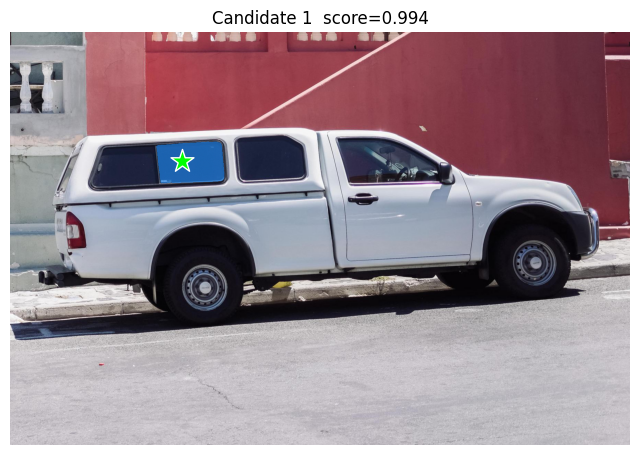

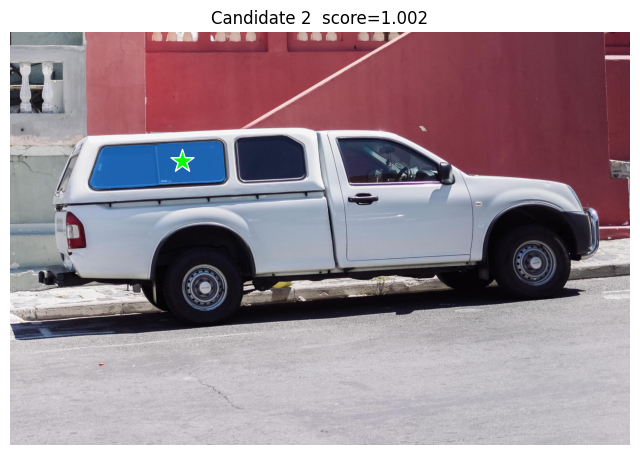

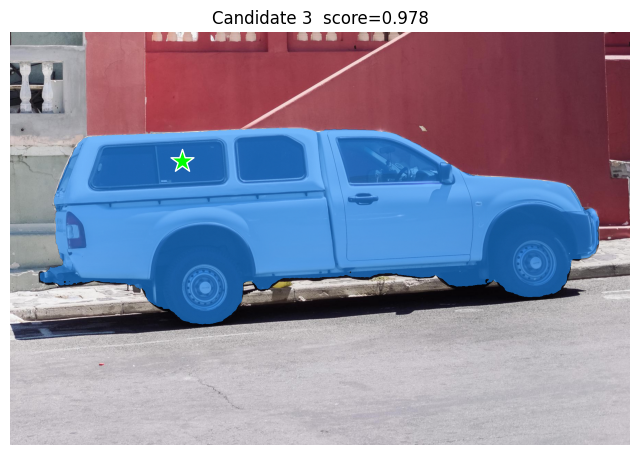

Best mask index: 2


In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

print("Masks shape:", masks.shape)   # (3, H, W)
print("Scores:", scores)

best_idx = int(np.argmax(scores))
best_mask = masks[best_idx].astype(bool)

# Visualize the 3 candidates
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(8,8))
    plt.imshow(image)
    show_mask(mask.astype(bool), plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Candidate {i+1}  score={score:.3f}")
    plt.axis("off")
    plt.show()

print("Best mask index:", best_idx + 1)

## 7. Optional refinement with more points

Why refine?
- One point can include extra stuff you do not want.
- Extra points help SAM lock onto the exact object.

How refinement works:
- We take the best low-res mask logits from the first run.
- We pass it back as `mask_input` so the next prediction starts from a strong guess.
- We set `multimask_output=False` to ask for one mask.

Try:
- Add a second foreground point on the same object
- Add a background point on a region you want to exclude

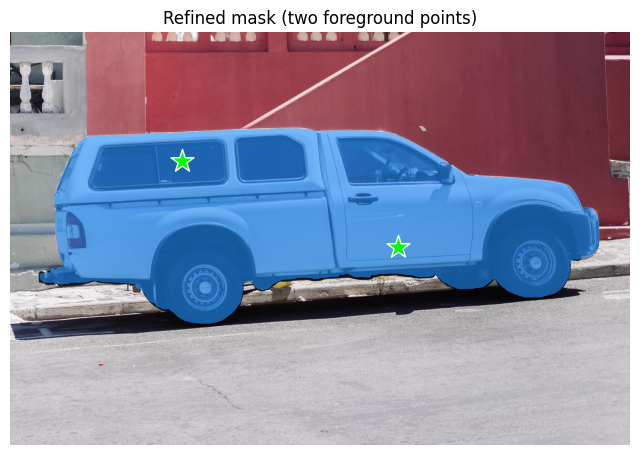

Using refined mask? True


In [ ]:
mask_input = logits[best_idx, :, :]

# Example refinement: add one more foreground point!
# Change these points based on what you see in your image.

if "truck" in IMAGE_PATH:
    refined_points = np.array([[500, 375], [1125, 625]])  # 2 foreground points
    refined_labels = np.array([1, 1], dtype=np.int32)
elif "groceries" in IMAGE_PATH:
    refined_points = np.array([[450, 300], [650, 420]])
    refined_labels = np.array([1, 1], dtype=np.int32)
else:
    refined_points = np.array([[W//2, H//2], [W//2 + 50, H//2 + 50]])
    refined_labels = np.array([1, 1], dtype=np.int32)

refined_masks, _, _ = predictor.predict(
    point_coords=refined_points,
    point_labels=refined_labels,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

refined_mask = refined_masks[0].astype(bool)

plt.figure(figsize=(8,8))
plt.imshow(image)
show_mask(refined_mask, plt.gca())
show_points(refined_points, refined_labels, plt.gca())
plt.title("Refined mask (two foreground points)")
plt.axis("off")
plt.show()

# Choose which mask to use going forward:
USE_REFINED = True
final_mask = refined_mask if USE_REFINED else best_mask
print("Using refined mask?" , USE_REFINED)

## 8. Save the mask

We save:
- A binary PNG (0 or 255), easy to reuse later
- A mask overlay image for your README and demos

Saved: outputs/mask_binary.png
Saved: outputs/mask_overlay.png


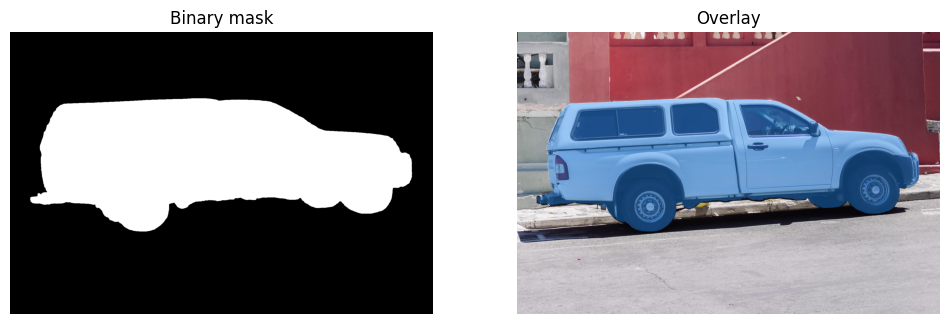

In [ ]:
from PIL import Image

os.makedirs("outputs", exist_ok=True)

mask_u8 = (final_mask.astype(np.uint8) * 255)

mask_path = "outputs/mask_binary.png"
Image.fromarray(mask_u8).save(mask_path)

# Overlay for quick viewing
overlay = image.copy()
overlay[final_mask] = (0.6 * overlay[final_mask] + 0.4 * np.array([30, 144, 255])).astype(np.uint8)

overlay_path = "outputs/mask_overlay.png"
Image.fromarray(overlay).save(overlay_path)

print("Saved:", mask_path)
print("Saved:", overlay_path)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(mask_u8, cmap="gray")
plt.title("Binary mask")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")
plt.show()

# Part B, Mosaic art using the SAM mask

Now we treat the mask as the shape boundary.
Everything we do from here will only apply inside the object.

1. Build a density field from brightness and edges
2. Restrict density to the mask
3. Sample points inside the mask
4. Render two outputs
   - Voronoi-style mosaic inside mask (pixel-based nearest-cell fill)
   - Delaunay triangle shading inside mask

## 9. Build a density field (brightness + edges), then restrict to the mask

We use:
- brightness term: darker areas get higher weight (often gives more detail on the subject)
- edge term: edges get higher weight (helps outlines and texture)

Then we multiply by the SAM mask so sampling only happens inside the object.

In [ ]:
from scipy import ndimage

def srgb_to_linear(u):
    u = np.clip(u, 0, 1)
    return np.where(u <= 0.04045, u/12.92, ((u + 0.055)/1.055)**2.4)

def luminance_linear(img_uint8):
    s = img_uint8.astype(np.float32) / 255.0
    r = srgb_to_linear(s[...,0])
    g = srgb_to_linear(s[...,1])
    b = srgb_to_linear(s[...,2])
    return 0.2126*r + 0.7152*g + 0.0722*b

Y = luminance_linear(image)  # (H, W) in [0,1]

# Edge magnitude on luminance
gx = ndimage.sobel(Y, axis=1, mode="reflect")
gy = ndimage.sobel(Y, axis=0, mode="reflect")
edge = np.hypot(gx, gy)
edge = edge / (edge.max() + 1e-8)

# Brightness term (choose one)
brightness_term = 1.0 - (Y / (Y.max() + 1e-8))  # prefer darker, often good for portraits and objects
brightness_term = np.clip(brightness_term, 0, 1)

# Combine
w_brightness = 0.6
w_edge = 0.4
density = w_brightness * brightness_term + w_edge * edge

# Restrict to mask only
density = density * final_mask.astype(np.float32)

density = np.clip(density, 1e-12, None)
pdf = density / density.sum()

print("Density sum:", float(density.sum()))
print("PDF sum:", float(pdf.sum()))

Density sum: 288298.40625
PDF sum: 0.9999999403953552


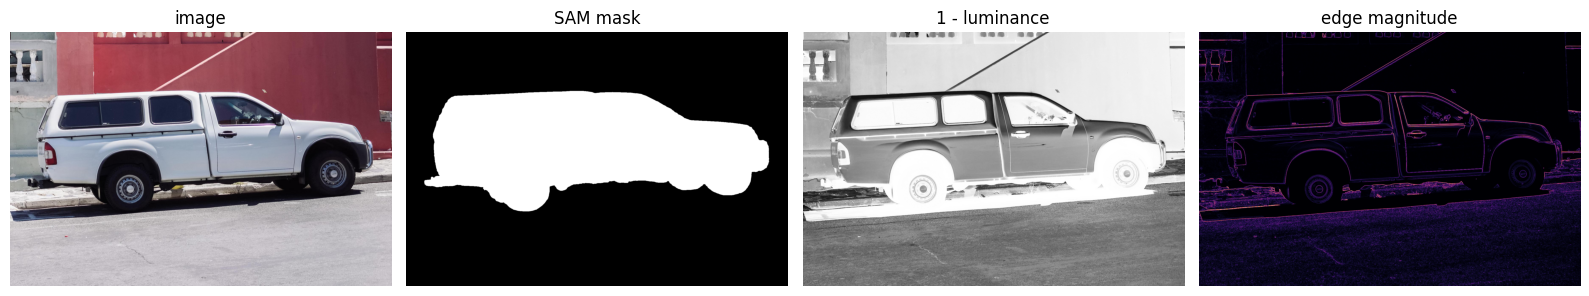

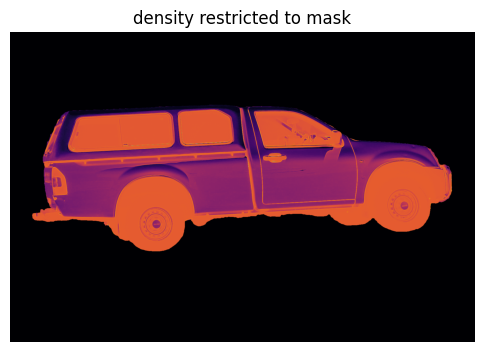

In [ ]:
# Visualize what we built
fig, axes = plt.subplots(1, 4, figsize=(16,4))
axes[0].imshow(image); axes[0].set_title("image"); axes[0].axis("off")
axes[1].imshow(final_mask, cmap="gray"); axes[1].set_title("SAM mask"); axes[1].axis("off")
axes[2].imshow(brightness_term, cmap="gray"); axes[2].set_title("1 - luminance"); axes[2].axis("off")
axes[3].imshow(edge, cmap="magma"); axes[3].set_title("edge magnitude"); axes[3].axis("off")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(density, cmap="inferno")
plt.title("density restricted to mask")
plt.axis("off")
plt.show()

## 10. Sample points inside the mask (from the masked PDF)

We sample pixel bins from `pdf`, then add small jitter inside each pixel so points are not stacked.
Points are stored in pixel coordinates `(x, y)`.

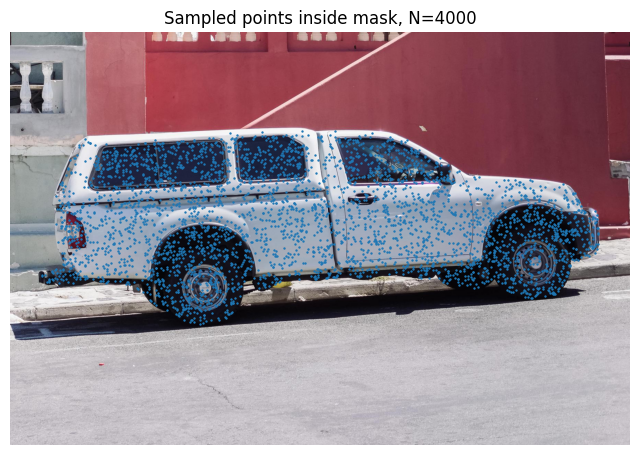

In [ ]:
rng = np.random.default_rng(123)

pdf_flat = pdf.ravel()
choices = np.arange(pdf_flat.size)

def sample_points_from_pdf(pdf_flat, W, H, N, rng):
    idx = rng.choice(choices, size=N, replace=True, p=pdf_flat)
    ys, xs = np.divmod(idx, W)
    xs = xs + rng.random(N)
    ys = ys + rng.random(N)
    return np.column_stack([xs, ys]).astype(np.float32)

N_points = 4000
pts = sample_points_from_pdf(pdf_flat, W, H, N_points, rng)

plt.figure(figsize=(8,8))
plt.imshow(image)
plt.scatter(pts[:,0], pts[:,1], s=0.5)
plt.title(f"Sampled points inside mask, N={N_points}")
plt.axis("off")
plt.show()

## 11. Optional: very light relaxation

Raw samples can clump. A small relaxation can make spacing nicer.

We do:
- 1 to 2 Lloyd-like steps in the image box
- After each step, we snap any outside points back into the nearest inside mask pixel

Important:
- Too many relaxation steps will wash out the density field.
- Keep it small, like 1 or 2.


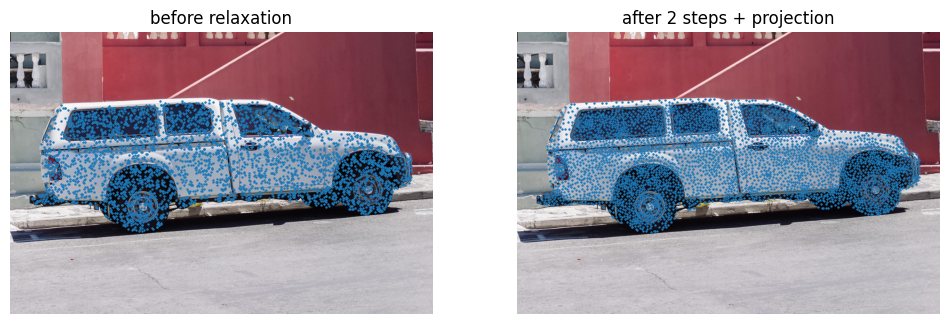

In [ ]:
from scipy.spatial import Voronoi

def polygon_centroid(poly):
    x, y = poly[:,0], poly[:,1]
    A = 0.5*np.sum(x*np.roll(y,-1) - np.roll(x,-1)*y)
    if abs(A) < 1e-10:
        return poly.mean(axis=0)
    cx = np.sum((x+np.roll(x,-1))*(x*np.roll(y,-1)-np.roll(x,-1)*y)) / (6*A)
    cy = np.sum((y+np.roll(y,-1))*(x*np.roll(y,-1)-np.roll(x,-1)*y)) / (6*A)
    return np.array([cx, cy])

def _clip_poly_to_box(poly, xmin, xmax, ymin, ymax):
    def clip_edge(points, inside, intersect):
        out = []
        if len(points) == 0:
            return out
        A = points[-1]
        for B in points:
            Ain, Bin = inside(A), inside(B)
            if Ain and Bin:
                out.append(B)
            elif Ain and not Bin:
                out.append(intersect(A, B))
            elif (not Ain) and Bin:
                out.append(intersect(A, B))
                out.append(B)
            A = B
        return out

    poly = poly.tolist()
    poly = clip_edge(poly,
                     inside=lambda p: p[0] >= xmin,
                     intersect=lambda A,B: [xmin, A[1] + (B[1]-A[1])*(xmin-A[0])/(B[0]-A[0]+1e-18)])
    poly = clip_edge(poly,
                     inside=lambda p: p[0] <= xmax,
                     intersect=lambda A,B: [xmax, A[1] + (B[1]-A[1])*(xmax-A[0])/(B[0]-A[0]+1e-18)])
    poly = clip_edge(poly,
                     inside=lambda p: p[1] >= ymin,
                     intersect=lambda A,B: [A[0] + (B[0]-A[0])*(ymin-A[1])/(B[1]-A[1]+1e-18), ymin])
    poly = clip_edge(poly,
                     inside=lambda p: p[1] <= ymax,
                     intersect=lambda A,B: [A[0] + (B[0]-A[0])*(ymax-A[1])/(ymax-A[1]+1e-18) if False else A[0] + (B[0]-A[0])*(ymax-A[1])/(B[1]-A[1]+1e-18), ymax])
    return np.array(poly, dtype=float)

def _voronoi_finite_polygons_2d(vor, radius=None):
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)

    if radius is None:
        radius = np.ptp(vor.points, axis=0).max() * 2

    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region_idx in enumerate(vor.point_region):
        verts = vor.regions[region_idx]
        if -1 not in verts:
            new_regions.append(verts)
            continue

        ridges = all_ridges[p1]
        new_verts = [v for v in verts if v != -1]
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0 and v2 >= 0:
                continue

            t = vor.points[p2] - vor.points[p1]
            t /= (np.linalg.norm(t) + 1e-18)
            n = np.array([-t[1], t[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_vertices.append(far_point.tolist())
            new_verts.append(len(new_vertices) - 1)

        vs = np.asarray([new_vertices[v] for v in new_verts])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1]-c[1], vs[:,0]-c[0])
        new_regions.append([v for _,v in sorted(zip(angles, new_verts))])

    return new_regions, np.asarray(new_vertices)

# Precompute nearest-inside projection using distance transform indices
# For outside pixels (~mask), this gives nearest inside pixel (mask==True).
dist, (iy, ix) = ndimage.distance_transform_edt(~final_mask, return_indices=True)

def project_points_to_mask(P, ix, iy, W, H, rng, jitter=0.25):
    P2 = P.copy()
    x = np.clip(np.round(P2[:,0]).astype(int), 0, W-1)
    y = np.clip(np.round(P2[:,1]).astype(int), 0, H-1)

    outside = ~final_mask[y, x]
    if np.any(outside):
        nx = ix[y[outside], x[outside]]
        ny = iy[y[outside], x[outside]]
        P2[outside, 0] = nx + rng.uniform(-jitter, jitter, size=nx.shape[0])
        P2[outside, 1] = ny + rng.uniform(-jitter, jitter, size=ny.shape[0])

    P2[:,0] = np.clip(P2[:,0], 0, W-1)
    P2[:,1] = np.clip(P2[:,1], 0, H-1)
    return P2

def lloyd_step_box_pixels(points, W, H):
    # One Lloyd step in the image bounding box (not mask-aware)
    vor = Voronoi(points)
    regions, vertices = _voronoi_finite_polygons_2d(vor)

    xmin, xmax, ymin, ymax = 0.0, float(W-1), 0.0, float(H-1)
    centroids = np.empty_like(points)

    for i, r in enumerate(regions[:len(points)]):
        poly = vertices[r]
        poly = _clip_poly_to_box(poly, xmin, xmax, ymin, ymax)

        if len(poly) < 3:
            centroids[i] = points[i]
        else:
            centroids[i] = polygon_centroid(poly)

    return centroids

# Run a tiny number of steps
relaxed = pts.copy()
for _ in range(2):
    relaxed = lloyd_step_box_pixels(relaxed, W, H)
    relaxed = project_points_to_mask(relaxed, ix, iy, W, H, rng)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.scatter(pts[:,0], pts[:,1], s=0.5)
plt.title("before relaxation")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(image)
plt.scatter(relaxed[:,0], relaxed[:,1], s=0.5)
plt.title("after 2 steps + projection")
plt.axis("off")
plt.show()

## 12. Render a Voronoi-style mosaic inside the SAM mask

- True polygon Voronoi needs clipping to a curved mask boundary, which is a pain without extra geometry libraries.
- Instead, we render the equivalent result by assigning each masked pixel to its nearest generator point.
That produces the correct Voronoi partition restricted to the mask, and it always matches the boundary perfectly.

Saved: outputs/mosaic_masked_voronoi_poly.png


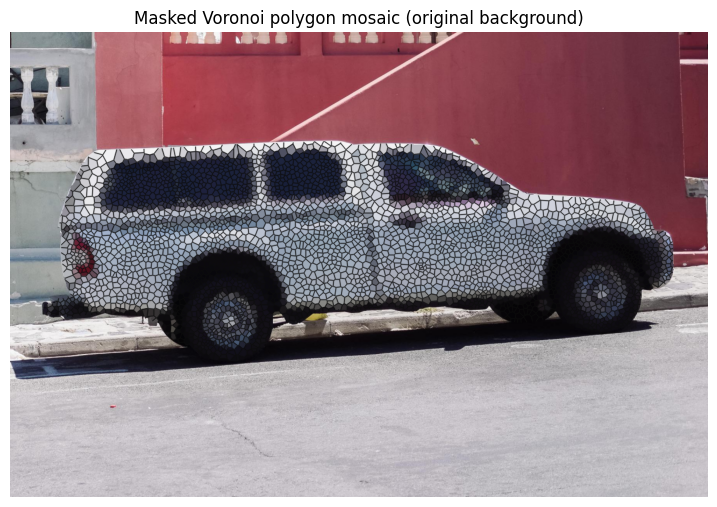

In [ ]:
import numpy as np
import cv2
from scipy.spatial import Voronoi
from PIL import Image
import matplotlib.pyplot as plt

def _clip_poly_to_box(poly, xmin, xmax, ymin, ymax):
    def clip_edge(points, inside, intersect):
        out = []
        if len(points) == 0:
            return out
        A = points[-1]
        for B in points:
            Ain, Bin = inside(A), inside(B)
            if Ain and Bin:
                out.append(B)
            elif Ain and not Bin:
                out.append(intersect(A, B))
            elif (not Ain) and Bin:
                out.append(intersect(A, B))
                out.append(B)
            A = B
        return out

    pts = poly.tolist()
    pts = clip_edge(
        pts,
        inside=lambda p: p[0] >= xmin,
        intersect=lambda A,B: [xmin, A[1] + (B[1]-A[1])*(xmin-A[0])/(B[0]-A[0] + 1e-18)]
    )
    pts = clip_edge(
        pts,
        inside=lambda p: p[0] <= xmax,
        intersect=lambda A,B: [xmax, A[1] + (B[1]-A[1])*(xmax-A[0])/(B[0]-A[0] + 1e-18)]
    )
    pts = clip_edge(
        pts,
        inside=lambda p: p[1] >= ymin,
        intersect=lambda A,B: [A[0] + (B[0]-A[0])*(ymin-A[1])/(B[1]-A[1] + 1e-18), ymin]
    )
    pts = clip_edge(
        pts,
        inside=lambda p: p[1] <= ymax,
        intersect=lambda A,B: [A[0] + (B[0]-A[0])*(ymax-A[1])/(B[1]-A[1] + 1e-18), ymax]
    )
    return np.array(pts, dtype=np.float32)

def _voronoi_finite_polygons_2d(vor, radius=None):
    if vor.points.shape[1] != 2:
        raise ValueError("Voronoi input must be 2D")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = np.ptp(vor.points, axis=0).max() * 2.0

    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region_idx in enumerate(vor.point_region):
        verts = vor.regions[region_idx]
        if -1 not in verts:
            new_regions.append(verts)
            continue

        ridges = all_ridges[p1]
        new_verts = [v for v in verts if v != -1]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0 and v2 >= 0:
                continue

            t = vor.points[p2] - vor.points[p1]
            t = t / (np.linalg.norm(t) + 1e-18)
            n = np.array([-t[1], t[0]], dtype=np.float32)

            midpoint = (vor.points[p1] + vor.points[p2]) * 0.5
            direction = np.sign(np.dot(midpoint - center, n)) * n

            far_point = vor.vertices[v2] + direction * radius
            new_vertices.append(far_point.tolist())
            new_verts.append(len(new_vertices) - 1)

        vs = np.asarray([new_vertices[v] for v in new_verts], dtype=np.float32)
        c = vs.mean(axis=0)
        ang = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_regions.append([v for _, v in sorted(zip(ang, new_verts))])

    return new_regions, np.asarray(new_vertices, dtype=np.float32)

def render_masked_voronoi_polygons(image, mask, points_xy, out_max_dim=1100, draw_edges=True, edge_color=(12, 12, 12), edge_thickness=1, color_mode="mean"):
    H, W = image.shape[:2]
    scale = 1.0
    if max(H, W) > out_max_dim:
        scale = out_max_dim / max(H, W)

    if scale < 1.0:
        newW = max(1, int(W * scale))
        newH = max(1, int(H * scale))
        img = cv2.resize(image, (newW, newH), interpolation=cv2.INTER_AREA)
        msk = cv2.resize(mask.astype(np.uint8), (newW, newH), interpolation=cv2.INTER_NEAREST).astype(bool)
        pts = points_xy.astype(np.float32).copy()
        pts[:, 0] *= scale
        pts[:, 1] *= scale
    else:
        img = image
        msk = mask.astype(bool)
        pts = points_xy.astype(np.float32).copy()

    h, w = img.shape[:2]

    px = np.clip(np.round(pts[:, 0]).astype(int), 0, w - 1)
    py = np.clip(np.round(pts[:, 1]).astype(int), 0, h - 1)
    inside = msk[py, px]
    pts_in = pts[inside]
    if len(pts_in) < 10:
        raise ValueError("Too few points inside the mask.")

    px = np.clip(np.round(pts_in[:, 0]).astype(int), 0, w - 1)
    py = np.clip(np.round(pts_in[:, 1]).astype(int), 0, h - 1)
    point_colors = img[py, px].astype(np.uint8)

    vor = Voronoi(pts_in)
    regions, vertices = _voronoi_finite_polygons_2d(vor, radius=max(h, w) * 2.0)

    out = img.copy()

    xmin, xmax, ymin, ymax = 0.0, float(w - 1), 0.0, float(h - 1)

    for i, region in enumerate(regions[:len(pts_in)]):
        poly = vertices[region]
        poly = _clip_poly_to_box(poly, xmin, xmax, ymin, ymax)
        if poly.shape[0] < 3:
            continue

        poly_i32 = np.round(poly).astype(np.int32)

        if color_mode == "mean":
            tmp = np.zeros((h, w), dtype=np.uint8)
            cv2.fillPoly(tmp, [poly_i32], 255)
            ys, xs = np.where((tmp == 255) & msk)
            if len(xs) == 0:
                col = point_colors[i]
            else:
                col = img[ys, xs].mean(axis=0).astype(np.uint8)
        else:
            col = point_colors[i]

        cv2.fillPoly(out, [poly_i32], color=tuple(int(x) for x in col.tolist()), lineType=cv2.LINE_AA)

        if draw_edges:
            cv2.polylines(out, [poly_i32], isClosed=True, color=edge_color, thickness=edge_thickness, lineType=cv2.LINE_AA)

    out[~msk] = img[~msk]
    return out

mosaic_img = render_masked_voronoi_polygons(
    image=image,
    mask=final_mask,
    points_xy=relaxed,
    out_max_dim=1200,
    draw_edges=True,
    edge_color=(12, 12, 12),
    edge_thickness=1,
    color_mode="mean"
)

mosaic_path = "outputs/mosaic_masked_voronoi_poly.png"
Image.fromarray(mosaic_img).save(mosaic_path)
print("Saved:", mosaic_path)
plt.figure(figsize=(9, 9))
plt.imshow(mosaic_img)
plt.title("Masked Voronoi polygon mosaic")
plt.axis("off")
plt.show()